In [1]:
%matplotlib notebook
import robostrategy.field as field
import roboscheduler.cadence as cadence
import numpy as np
import fitsio

/usr/local/sdss/products/sdssdb/trunk/python/sdssdb/__init__.py:32: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(open(os.path.dirname(__file__) + '/etc/{0}.yml'.format(NAME)))
/usr/local/sdss/products/sdssdb/trunk/python/sdssdb/__init__.py:37: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = merge(yaml.load(open(custom_config_fn)), config)


### Reading in cadences as prep

Read in the cadences necessary from a file.

In [2]:
cl = cadence.CadenceList()
cl.fromfits('rsCadencesNew2.fits')

### Initializing a Field

Read in an example set of targets from a previous run of robostrategy and set its cadence and other settings. We really are only going to use the target list from this file.

In [3]:
a, hdr = fitsio.read('rsFieldAssignments-delta-test-all-2-apo-1122.fits', header=True)

racen = np.float64(hdr['RACEN'])
deccen = np.float64(hdr['DECCEN'])
field_cadence = 'bhm_aqmes_wide_3x4'
observatory = 'apo'
pa = 15.

Set the cadences for the standards so that Field will put them on every exposure.

In [4]:
icalib_boss = np.where((a['category'] == 'sky_boss') |
                       (a['category'] == 'standard_boss'))[0]
a['cadence'][icalib_boss] = field_cadence
icalib_apogee = np.where((a['category'] == 'sky_apogee') |
                         (a['category'] == 'standard_apogee'))[0]
a['cadence'][icalib_apogee] = field_cadence

Instantiate the field, and load the targets into it.

In [5]:
f = field.Field(racen=racen, deccen=deccen, pa=pa,
                field_cadence=field_cadence, observatory=observatory)

f.targets_fromarray(a)

Do you have some other targets you want to add to the field? You can add them by calling targets_fromarray() again:

In [6]:
print(len(f.targets))
b = np.zeros(10, dtype=a.dtype)
b['ra'] = racen + np.random.random(len(b)) - 0.5
b['dec'] = deccen + np.random.random(len(b)) - 0.5
b['rsid'] = a['rsid'].max() + 1 + np.arange(len(b), dtype=np.int32)
b['catalogid'] = a['catalogid'].max() + 1 + np.arange(len(b), dtype=np.int32)
b['cadence'] = 'mwm_galactic_1x1'
b['category'] = 'science'
b['carton'] = 'mike_fake'
b['value'] = 1.
b['priority'] = 100000
f.targets_fromarray(b)
print(len(f.targets))

4407
4417


### Assign targets and review results

Assign all the targets.

In [7]:
f.assign()

Run a validation. Returns the number of problems detected. This looks for collisions, but also looks for internal inconsistencies in how the Field object is tracking the assignments.

In [8]:
print(f.validate())

0


Print some basic statistics of the field

In [9]:
print(f.assess())

Field cadence: bhm_aqmes_wide_3x4

Calibration targets: sky_boss (want 80): 80 80 80 80 80 80 80 80 80 80 80 80
 standard_boss (want 80): 80 80 80 80 80 80 80 80 89 89 89 89
 sky_apogee (want 30): 30 30 30 30 30 30 30 30 41 41 41 41
 standard_apogee (want 20): 36 36 36 36 37 37 37 37 168 168 168 168

Science targets:
 BOSS targets assigned: 340
 APOGEE targets assigned: 109
 Targets per epoch: 397 356 122



<IPython.core.display.Javascript object>


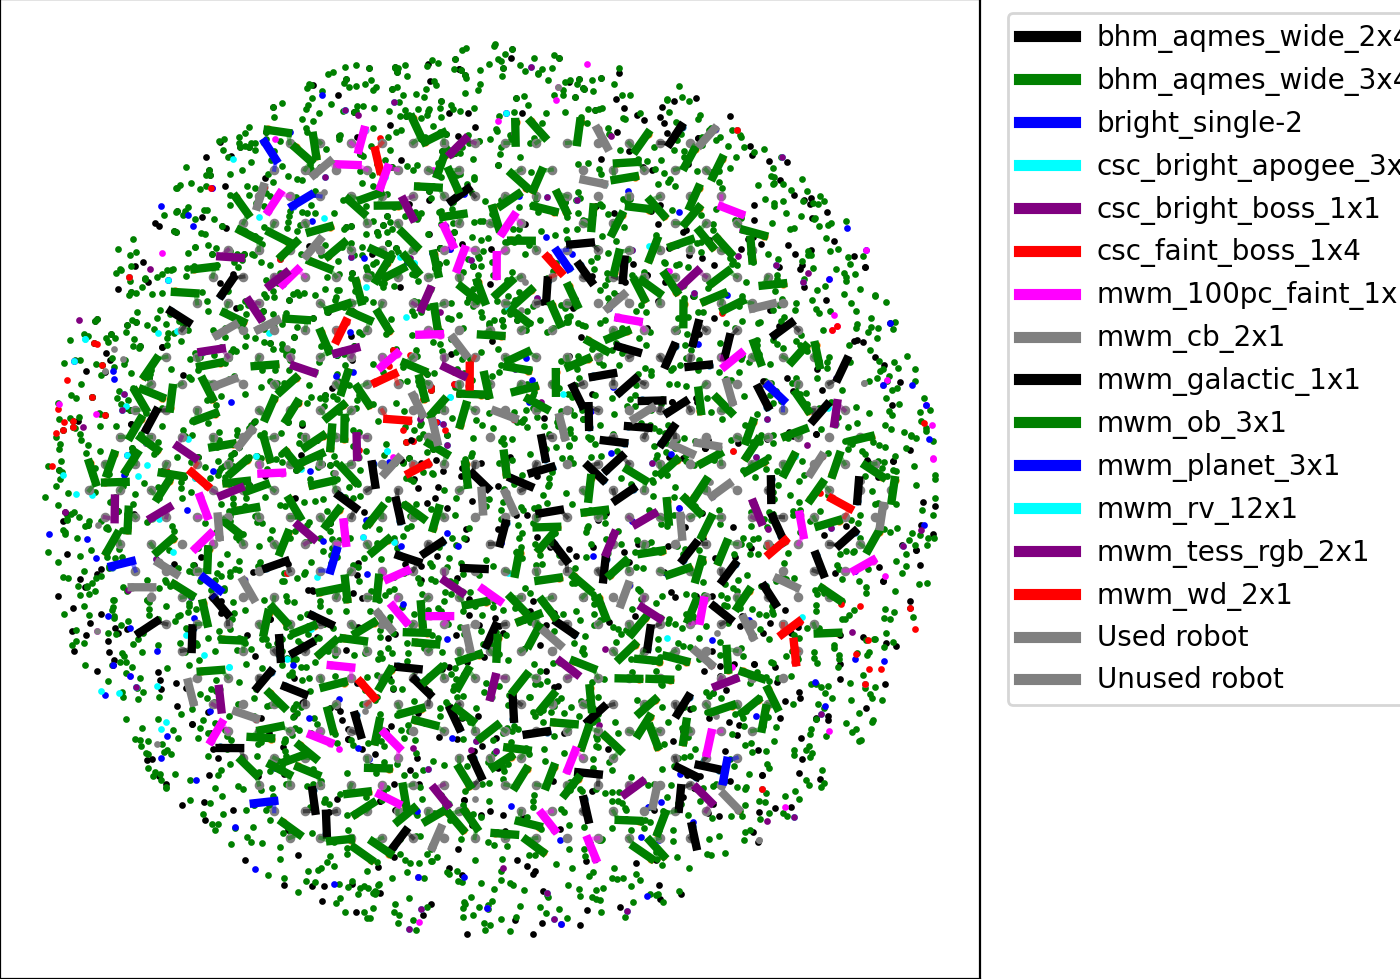

In [10]:
f.plot(iexp=0)

### Input and Output of the results

Output in new FITS format for Field objects.

In [11]:
f.tofits(filename='test_fieldnew_out.fits')

The easiest way to access this output is to read it into a Field object.

In [12]:
g = field.Field(filename='test_fieldnew_out.fits')

In [13]:
print(g.validate())
print(g.assess())

0
Field cadence: bhm_aqmes_wide_3x4

Calibration targets: sky_boss (want 80): 80 80 80 80 80 80 80 80 80 80 80 80
 standard_boss (want 80): 80 80 80 80 80 80 80 80 89 89 89 89
 sky_apogee (want 30): 30 30 30 30 30 30 30 30 41 41 41 41
 standard_apogee (want 20): 36 36 36 36 37 37 37 37 168 168 168 168

Science targets:
 BOSS targets assigned: 340
 APOGEE targets assigned: 109
 Targets per epoch: 397 356 122



### How information is stored in Field

The information about the targets and how they are assigned to robots is in the "targets" and "assignments" attributes. The targets array includes:

* ra (Right Ascension in the J2000 equinox, 64-bit floating point, deg)
* dec (Declination in the J2000 equinox, 64-bit floating point, deg)
* x (x position in focal plane) - necessary for now the way kaiju works
* y (y position in focal plane)
* within (whether it is covered by a robot)
* priority (priority number; lower numbers go first)
* category ('science', 'sky_boss', 'standard_boss', 'sky_apogee', 'standard_apogee')
* cadence (cadence name)
* fiberType ('APOGEE', 'BOSS')
* catalogid (catalogid from catalogdb)
* rsid (robostrategy id)
* target_pk (pk in targetdb; not used here)

The assignments array includes:

* assigned (is it assigned in any exposure?)
* robotID[] (which robotID it is assigned to in each exposure; -1 if unassigned)
* fiberType ('APOGEE', 'BOSS')
* rsflags (result flags; currently unused)

In [14]:
print(f.targets.dtype)
print(f.targets[0])
print(f.targets[1000])

[('ra', '<f8'), ('dec', '<f8'), ('x', '<f8'), ('y', '<f8'), ('within', '<i4'), ('priority', '<i4'), ('category', '<U30'), ('cadence', '<U30'), ('fiberType', '<U10'), ('catalogid', '<i8'), ('rsid', '<i8'), ('target_pk', '<i8')]
( 228.884341,  55.55747152, -47.7029687,  66.72530851, 1, 1200, 'science', 'bhm_aqmes_wide_3x4', 'BOSS', 4346763970, 19756, 0)
( 228.979148,  56.322403, -79.24069179,  230.87970502, 1, 4000, 'science', 'csc_bright_apogee_3x1', 'APOGEE', 4346729942, 3162375, 0)


In [15]:
print(f.assignments.dtype)
print(f.assignments[0])
print(f.assignments[1000])

[('assigned', '<i4'), ('robotID', '<i4', (12,)), ('fiberType', '<U10'), ('rsflags', '<i4')]
(1, [163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163], 'BOSS', 0)
(0, [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], 'APOGEE', 0)


"targets" and "assignments" are ndarrays so elements are referenced by index. But the targets are named by a unique rsid in this process. To quickly find the index of an element associated with some rsid requires a separate dictionary, which is rsid2indx. rsid2indx is demonstrated below:

In [16]:
print(f.targets['rsid'][12])
print(f.rsid2indx[22513])

22513
12


The information about the robots and how they are assigned to targets for each exposure is in the robotgrids list (of RobotGridFilledHex objects). The RobotGridFilledHex objects are from kaiju. Each object contains the information pertinent to each exposure---i.e. a design.

In [17]:
f.robotgrids

Each robotgrid has a robot dictionary. For each robot, it knows which targets it can reach, and which it is assigned to.

In [18]:
f.robotgrids[0].robotDict[0].validTargetIDs

[466192,
 658721,
 21137731,
 22681865,
 24981483,
 25447375,
 28435135,
 28726830,
 29407280,
 30545572,
 31004038,
 32812287]

In [19]:
f.robotgrids[0].robotDict[0].assignedTargetID

658721

In [20]:
f.robotgrids[0].targetDict[658721].isAssigned()

True

The robotgrid can also report if a robot is collided.

In [21]:
f.robotgrids[0].isCollidedWithAssigned(0)

False

E.g. if I reassign the target manually, it causes a collision.

In [22]:
f.robotgrids[0].assignRobot2Target(0, 32812287)
print(f.robotgrids[0].isCollidedWithAssigned(0))

True


However, the Field object won't like that. Because it has to keep track of all the epochs, and needs to operate efficiently, it keeps some internal variables. These variables will become inconsistent if you try to directly manipulate the robotgrids in this context.

In [23]:
f.validate()

rsid=658721 epoch=0 : robots not assigned (4 out of 4)
robotID=0 iexp=0 : collision of assigned robot
robotID=215 iexp=0 : collision of assigned robot
robotID=0 iexp=0 : expected 3901 in _robot2indx got 570


4

In [24]:
f.robotgrids[0].assignRobot2Target(0, 658721)
f.validate()

0

However, for downstream use by the operations, the RobotGridFilledHex has everything in it for  kaiju/jaeger to use. 

robotgrids could be replaced with "designs", which were a subclass with all the information in a robotgrid, but with the ability to communicate with the database and all the information about the design stored in the database built into it (racen, deccen, PA, LST recommendations, etc).

Within the context of dealing with a single design, you can reassign robots or whatever.

### Assigning more targets

A use case for this class is to add additional targets in a roboreassign or open fiber program context. Basic functionality for this purpose exists.

In [25]:
# Reading in field again for convenience (because it resets all the monkeying within the field below)
f = field.Field(filename='test_fieldnew_out.fits') 

To set up an example, we first want to find the unassigned robots in some exposure (here we look at the first exposure, iexp=0). There are two ways of doing this, one of which is considered visible to functions acting with the object, the other of which should really only be used within methods of the class.

In [26]:
# Here is the straightforward way of finding unassigned robots
iexp = 0
for robotID in f.robotgrids[iexp].robotDict:
    if(f.robotgrids[iexp].robotDict[robotID].isAssigned() is False):
        print(robotID)
        
# But the Field object keeps track of the robots
# in an internal array that makes things faster.
inot = np.where(f._robot2indx[:, iexp] < 0)[0]
print(inot)

183
187
209
230
240
269
304
314
317
386
424
494
[183 187 209 230 240 269 304 314 317 386 424 494]


Let us look at robotID = 183, and see what it does with its 12 exposures:

In [27]:
print(f._robot2indx[183, :])

[  -1 1381 1020 1325   -1 1381 1020 1325 2422 2422 2422 2422]


So it is idle in exposures 0 and 4. What are the other targets targeted? Let's look at them. Note that the "_robot2indx" array yields the index. So you need to reference the targets array if you want the rsids.

In [28]:
for indx in f._robot2indx[183, :]:
    if(indx >= 0):
        print("rsid {rsid}, {cat} target with cadence {cad}".
              format(rsid=f.targets['rsid'][indx],
                     cat=f.targets['category'][indx],
                     cad=f.targets['cadence'][indx]))

rsid 5574170, science target with cadence mwm_cb_2x1
rsid 3183673, science target with cadence mwm_wd_2x1
rsid 5253807, science target with cadence mwm_cb_2x1
rsid 5574170, science target with cadence mwm_cb_2x1
rsid 3183673, science target with cadence mwm_wd_2x1
rsid 5253807, science target with cadence mwm_cb_2x1
rsid 24031837, standard_boss target with cadence bhm_aqmes_wide_3x4
rsid 24031837, standard_boss target with cadence bhm_aqmes_wide_3x4
rsid 24031837, standard_boss target with cadence bhm_aqmes_wide_3x4
rsid 24031837, standard_boss target with cadence bhm_aqmes_wide_3x4


In any case, for exposure 0, we can ask whether any of the targets the robot can reach would cause a collision with an assigned robot. This method relies on internal kaiju calculations.

In [29]:
for tid in f.mastergrid.robotDict[183].validTargetIDs:
    wc = f.collide_robot_exposure(iexp=iexp, robotID=183, rsid=tid)
    if(wc):
        print("targetID {tid} would collide with an assigned robot".format(tid=tid))
    else:
        print("targetID {tid} would NOT collide with an assigned robot".format(tid=tid))

targetID 659754 would NOT collide with an assigned robot
targetID 659880 would collide with an assigned robot
targetID 3183673 would collide with an assigned robot
targetID 5253807 would collide with an assigned robot
targetID 5519742 would NOT collide with an assigned robot
targetID 5574170 would collide with an assigned robot
targetID 22320021 would NOT collide with an assigned robot
targetID 22451410 would NOT collide with an assigned robot
targetID 24031837 would NOT collide with an assigned robot
targetID 24493445 would NOT collide with an assigned robot
targetID 24983433 would NOT collide with an assigned robot
targetID 28043326 would collide with an assigned robot
targetID 29394422 would NOT collide with an assigned robot
targetID 29707728 would NOT collide with an assigned robot
targetID 29767665 would NOT collide with an assigned robot
targetID 33020806 would NOT collide with an assigned robot
targetID 34523884 would NOT collide with an assigned robot
targetID 34776898 would N

rsid=659754 is a possible target. Let's pretend that we have identified that target as one where we'd be happy with an exposure of some sort. It is a science target, and has not been assigned any fibers.

In [30]:
print(f.targets[f.rsid2indx[659754]])
print(f.assignments[f.rsid2indx[659754]])

( 229.10740338,  55.30116832, -6.67167012,  19.82458608, 1, 3300, 'science', 'bhm_aqmes_wide_2x4', 'BOSS', 5981121219, 659754, 0)
(0, [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], 'BOSS', 0)


We can assign it to exposure 0.

In [31]:
f.assign_robot_exposure(rsid=659754, robotID=183, iexp=0)
f.decollide_unassigned()

In [32]:
print(f.targets[f.rsid2indx[659754]])
print(f.assignments[f.rsid2indx[659754]])

( 229.10740338,  55.30116832, -6.67167012,  19.82458608, 1, 3300, 'science', 'bhm_aqmes_wide_2x4', 'BOSS', 5981121219, 659754, 0)
(1, [183,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1], 'BOSS', 0)


Validation will complain because the this assignment is a violation of the cadence requirements. Maybe the validate() method should treat these cases differently!

In [33]:
print(f.validate())

rsid=659754 epoch=0 : nexp mismatch
rsid=659754 epoch=0 : robots not assigned (1 out of 4)
rsid=659754 : target assigned with wrong nepochs
3


Just to clean things back up, we can unassign it.

In [34]:
f.unassign_exposure(rsid=659754, iexp=0)

In [35]:
print(f.validate())

0


### Recommended way to try to add a target

Probably the best way to implement new targets or exposures of targets is to use available_epochs() to find available epochs for each target, and then use assign_epochs() to assign them. The reason is that (right now) these routines deal with the logic of dealing with spare calibration targets, and that (in the future) they can be the vehicle for implementing some optimizations, like shifting robots to deal with collisions or used robots. For example:

In [36]:
available =  f.available_epochs(rsid=659754)

So we learn that at each epoch, it is robotID=183 that is available:

In [37]:
print(available['availableRobotIDs'])

[[183], [183], [183]]


There is 1 exposure free in each of the first two epochs, and 4 in the third (because it is allowing us to bump the calibration target there).

In [38]:
print(available['nFrees'])

[[1], [1], [4]]


It also returns a list of those spare calibrations.

In [39]:
print(available['spareCalibrations'])

[[array([], dtype=int64)], [array([], dtype=int64)], [array([24031837])]]


Now I can assign to the epochs:

In [40]:
f.assign_epochs(rsid=659754, epochs=[0, 2], nexps=[1, 3])

True

In [41]:
print(f.assignments[f.rsid2indx[659754]])

(1, [183,  -1,  -1,  -1,  -1,  -1,  -1,  -1, 183, 183, 183,  -1], 'BOSS', 0)


And again validate() will complain.

In [42]:
f.validate()

rsid=659754 epoch=0 : nexp mismatch
rsid=659754 epoch=0 : robots not assigned (1 out of 4)
rsid=659754 epoch=2 : nexp mismatch
rsid=659754 epoch=2 : robots not assigned (3 out of 4)


4